In [39]:
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import seaborn as sns
from reliability_diagrams import *
import pandas as pd
from scipy.stats import t, ttest_1samp, ttest_ind
import itertools

In [2]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [3]:
def topn_error(preds, labels, n):
    correct = 0
    for i, label in enumerate(labels):
        if np.isin(label, preds[i, :n]): correct += 1

    return 1 - (correct / len(labels))

In [6]:
def non_parametric_bootstrap(y_true, y_pred, y_conf, n, iters=1000, seed=8, bins=20):

    np.random.seed(seed)
    eces = np.zeros(iters)
    for i in range(iters):
        new_samp = np.random.choice(range(len(y_true)), size=n, replace=True)
        y_true_samp = y_true[new_samp]
        y_pred_samp = y_pred[new_samp]
        y_conf_samp = y_conf[new_samp]
        eces[i] = compute_calibration(y_true_samp, y_pred_samp, y_conf_samp, num_bins=bins)['expected_calibration_error']

    return eces    

In [4]:
# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

/var/folders/zj/m7t63tn57zj6156pfxpr2bhw0000gn/T/ipykernel_30121/1379399127.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


shufflenet_v2_x1_0
Top 5 error: 0.11563919268446676
Top 1 error: 0.3048614081179609
ECE: 0.07275042673516185


/Users/daniel/Desktop/MA417/nn-confidence/reliability_diagrams.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


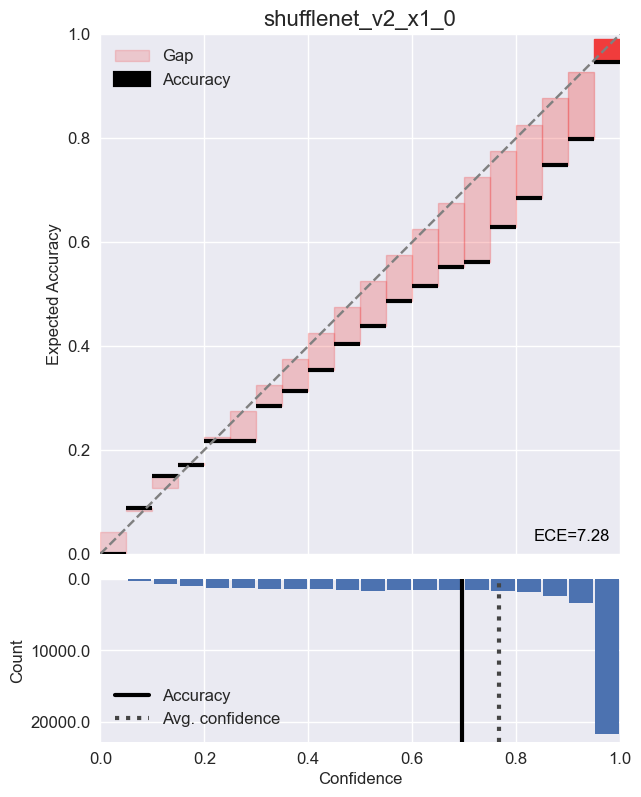

/var/folders/zj/m7t63tn57zj6156pfxpr2bhw0000gn/T/ipykernel_30121/2658647066.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


95% confidence low: 0.06995834972112816
95% confidence high: 0.07627732989339715


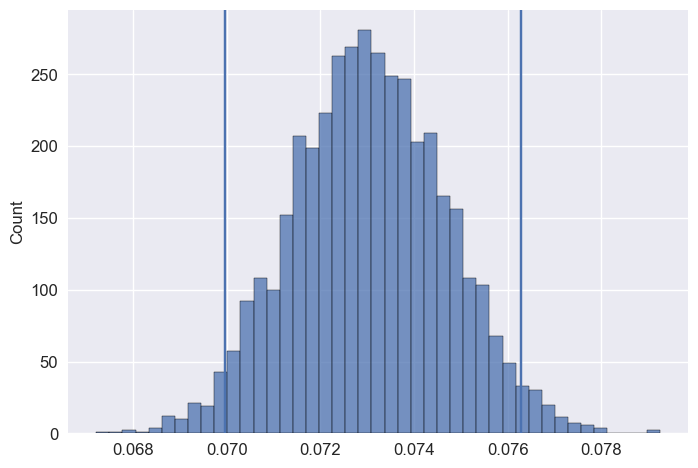


densenet121
Top 5 error: 0.07975397649742366
Top 1 error: 0.2547809616912079
ECE: 0.02510593713018915


/Users/daniel/Desktop/MA417/nn-confidence/reliability_diagrams.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


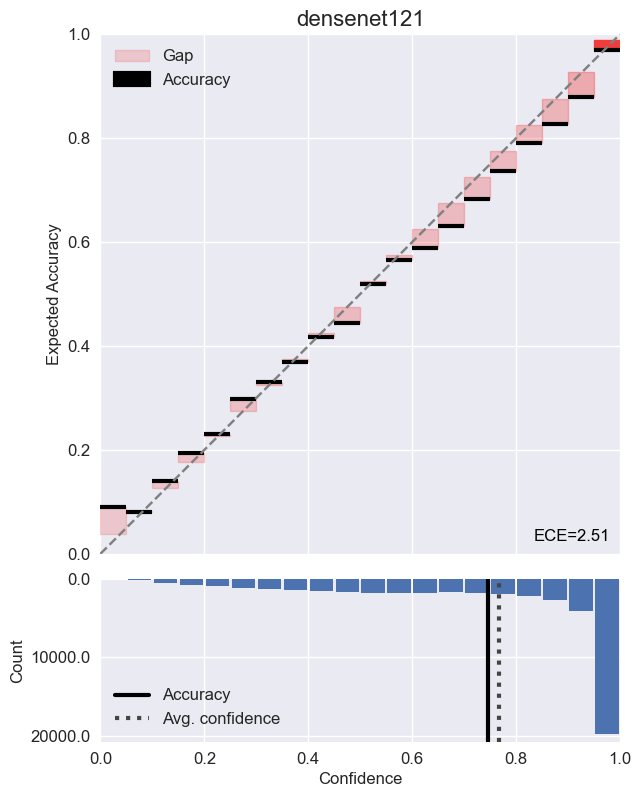

/var/folders/zj/m7t63tn57zj6156pfxpr2bhw0000gn/T/ipykernel_30121/2658647066.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


95% confidence low: 0.023291988706122552
95% confidence high: 0.029052768785045598


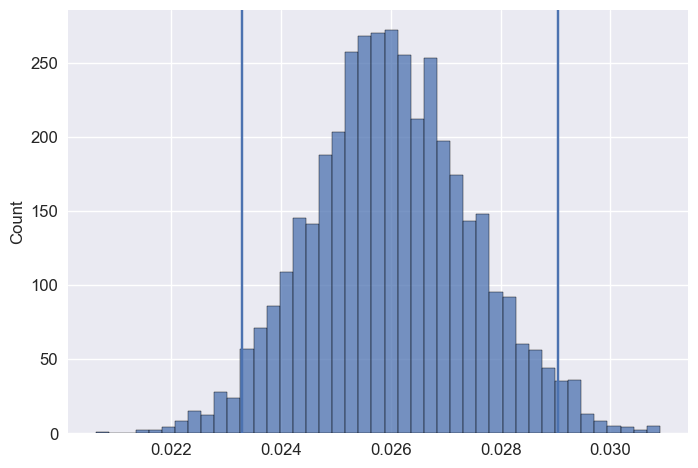


resnet18
Top 5 error: 0.1082666340807723
Top 1 error: 0.30117512881611375
ECE: 0.026492637438785983


/Users/daniel/Desktop/MA417/nn-confidence/reliability_diagrams.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


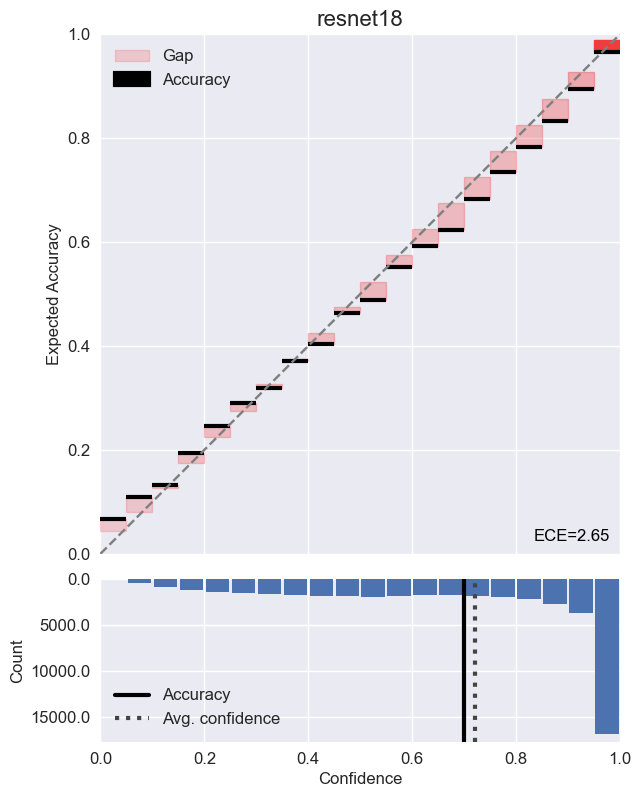

/var/folders/zj/m7t63tn57zj6156pfxpr2bhw0000gn/T/ipykernel_30121/2658647066.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


95% confidence low: 0.023919589716078236
95% confidence high: 0.03015560816770457


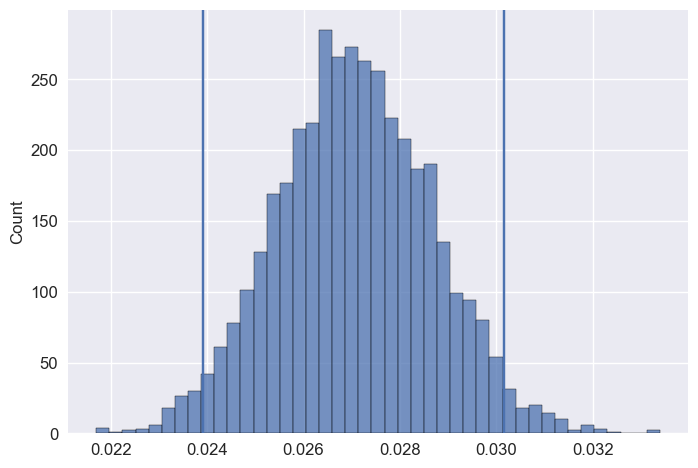

In [20]:
models = ['shufflenet_v2_x1_0', 'densenet121', 'resnet18']
ece_samps = []
#models = ['shufflenet_v2_x1_0']
for model in models:
    print(model)
    preds = np.array(pd.read_csv(model + '/preds.csv', index_col=0))[:49101]
    probs = np.array(pd.read_csv(model + '/probs.csv', index_col=0))[:49101]
    labels = np.array(pd.read_csv(model + '/labels.csv', index_col=0)).flatten()[:49101]

    #print(labels.shape)
    print("Top 5 error:", topn_error(preds, labels, n=5))
    print("Top 1 error:", topn_error(preds, labels, n=1))

    y_true = labels
    y_pred = preds[:,0]
    y_conf = probs[:,0]
    bins = 20
    
    print("ECE:", compute_calibration(y_true, y_pred, y_conf, num_bins=bins)['expected_calibration_error'])    

    title = model
    fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=bins, draw_ece=True,
                            draw_bin_importance="alpha", draw_averages=True,
                            title=title, figsize=(6, 6), dpi=100, 
                            return_fig=True)
    fig.show()

    ece_samp = non_parametric_bootstrap(y_true, y_pred, y_conf, n=len(y_true), iters=4000, bins=bins)
    ece_samps.append(ece_samp)
    low_conf, high_conf = np.quantile(ece_samp, [0.025, .975])
    print("95% confidence low:", low_conf)
    print("95% confidence high:", high_conf)
    sns.histplot(ece_samp)
    plt.axvline(low_conf)
    plt.axvline(high_conf)
    plt.show()
    print()

In [37]:
def twoside_ttest(samp, mu0):
    n = len(samp)
    test = (samp.mean() - mu0) / (samp.std() / np.sqrt(n))
    print(test)
    return 2*(1-t.cdf(test, n-1))

In [38]:
#testing between optimal value of 0 and ECE vallue for each
for i in range(3):
    print(models[i])
    print(twoside_ttest(ece_samps[i], 0))
    print(ttest_1samp(ece_samps[i], 0))
    print()

shufflenet_v2_x1_0
2835.442715904956
0.0
TtestResult(statistic=2835.0882634108025, pvalue=0.0, df=3999)

densenet121
1128.556549685647
0.0
TtestResult(statistic=1128.415471298986, pvalue=0.0, df=3999)

resnet18
1066.867625000893
0.0
TtestResult(statistic=1066.7342582118224, pvalue=0.0, df=3999)



In [41]:
#testing between ECEs of each group
for i,j in itertools.combinations(range(3),2):
    print(models[i], 'and', models[j])
    print(ttest_ind(ece_samps[i], ece_samps[j]))

shufflenet_v2_x1_0 and densenet121
Ttest_indResult(statistic=1359.627033905429, pvalue=0.0)
shufflenet_v2_x1_0 and resnet18
Ttest_indResult(statistic=1271.804735462872, pvalue=0.0)
densenet121 and resnet18
Ttest_indResult(statistic=-30.118348822989777, pvalue=7.245823776752543e-189)
